In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols

In [2]:
df = pd.read_csv('custdata.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
custid          1000 non-null int64
sex             1000 non-null object
is.employed     672 non-null object
income          1000 non-null int64
marital.stat    1000 non-null object
health.ins      1000 non-null bool
housing.type    944 non-null object
recent.move     944 non-null object
num.vehicles    944 non-null float64
age             1000 non-null float64
state.of.res    1000 non-null object
dtypes: bool(1), float64(2), int64(2), object(6)
memory usage: 79.2+ KB


In [4]:
df.head(10)

,custid,sex,is.employed,income,marital.stat,health.ins,housing.type,recent.move,num.vehicles,age,state.of.res
0,2068,F,NaN,11300,Married,True,Homeowner free and clear,False,2.0,49.0,Michigan
1,2073,F,NaN,0,Married,True,Rented,True,3.0,40.0,Florida
2,2848,M,True,4500,Never Married,False,Rented,True,3.0,22.0,Georgia
3,5641,M,True,20000,Never Married,False,Occupied with no rent,False,0.0,22.0,New Mexico
4,6369,F,True,12000,Never Married,True,Rented,True,1.0,31.0,Florida
5,8322,F,True,180000,Never Married,True,Homeowner with mortgage/loan,False,1.0,40.0,New York
6,8521,M,True,120000,Never Married,True,Homeowner free and clear,True,1.0,39.0,Idaho
7,12195,M,True,40000,Married,True,Rented,False,3.0,48.0,Michigan
8,14989,M,NaN,9400,Married,True,Rented,False,2.0,44.0,Illinois
9,15917,F,True,24000,Divorced/Separated,True,Homeowner free and clear,False,1.0,70.0,North Carolina


In [5]:
# Cleaning and preparation
df['is.employed'].fillna(value = 'Unknown', inplace = True)
df = df[df['housing.type'].notnull()]
df = df[(df['age'] > 0) & (df['age'] < 99)]

# Convert target to 1 and 0
df['health_ins_num'] = 1
df['health_ins_num'][~df['health.ins']] = 0
df.drop('health.ins',axis = 1, inplace = True)

C:\Users\maikh\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
df['health_ins_num'].value_counts()

1    796
0    137
Name: health_ins_num, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 933 entries, 0 to 999
Data columns (total 11 columns):
custid            933 non-null int64
sex               933 non-null object
is.employed       933 non-null object
income            933 non-null int64
marital.stat      933 non-null object
housing.type      933 non-null object
recent.move       933 non-null object
num.vehicles      933 non-null float64
age               933 non-null float64
state.of.res      933 non-null object
health_ins_num    933 non-null int64
dtypes: float64(2), int64(3), object(6)
memory usage: 87.5+ KB


## First logistics model

In [8]:
x = df[['age','income']]
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,df['health_ins_num'],
                                                    test_size = 0.4,
                                                   random_state = 10)

In [9]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(x_train, y_train)

C:\Users\maikh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
# Evaluation
p_predict = logmodel.predict_proba(x_test)[:,1]
p_predict[:5]

array([0.91992978, 0.84432437, 0.84767052, 0.97034289, 0.94808297])

In [11]:
logmodel.intercept_

array([0.00017679])

In [12]:
logmodel.coef_

array([[2.25632638e-02, 1.56035781e-05]])

In [13]:
x_test.head(3)

,age,income
577,75.0,48000
323,64.0,15800
197,65.0,16000


In [14]:
# New customer: Age = 50, Income = 80k
new_customer = pd.DataFrame({'age': [50], 'income':[80000]})
logmodel.predict_proba(new_customer)[:,1]  # Predict probability

array([0.91502748])

In [15]:
# Predict classification
logmodel.predict(new_customer)  # value 1

array([1], dtype=int64)

In [16]:
# Manual classification
p_predict = logmodel.predict_proba(x_test)[:,1]
predictions = [1 if v > 0.5 else 0 for v in p_predict]
predictions[:20]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [17]:
# Evaluation
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, predictions)

In [18]:
confusion

array([[  0,  45],
       [  0, 329]], dtype=int64)

In [19]:
# Precision
from sklearn.metrics import accuracy_score, precision_score, recall_score# 264/(264+17)
print('Accuracy: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))


Accuracy: 0.88
Recall: 1.00
Accuracy: 0.88


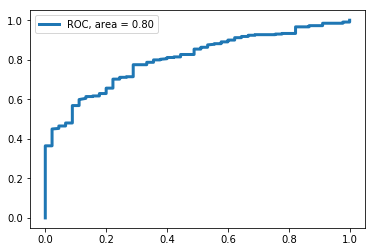

In [20]:
# ROC: Receiving Operation Curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_score = logmodel.decision_function(x_test)
fpr, tpr, _ = roc_curve(y_test, y_score)
auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, lw = 3, label = "ROC, area = {:0.2f}".format(auc))
plt.legend()

## Second logistics model 

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 933 entries, 0 to 999
Data columns (total 11 columns):
custid            933 non-null int64
sex               933 non-null object
is.employed       933 non-null object
income            933 non-null int64
marital.stat      933 non-null object
housing.type      933 non-null object
recent.move       933 non-null object
num.vehicles      933 non-null float64
age               933 non-null float64
state.of.res      933 non-null object
health_ins_num    933 non-null int64
dtypes: float64(2), int64(3), object(6)
memory usage: 87.5+ KB


In [22]:
sex_dummy = pd.get_dummies(df['sex'], drop_first = True)
housing_dummy = pd.get_dummies(df['housing.type'], drop_first = True)
marital_dummy = pd.get_dummies(df['marital.stat'], drop_first = True)

x = df.drop(['custid','health_ins_num','sex','housing.type','is.employed',
             'marital.stat','recent.move','num.vehicles',
            'state.of.res'], axis = 1)
x = pd.concat([x,sex_dummy, housing_dummy, marital_dummy],axis=1)
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 933 entries, 0 to 999
Data columns (total 9 columns):
income                          933 non-null int64
age                             933 non-null float64
M                               933 non-null uint8
Homeowner with mortgage/loan    933 non-null uint8
Occupied with no rent           933 non-null uint8
Rented                          933 non-null uint8
Married                         933 non-null uint8
Never Married                   933 non-null uint8
Widowed                         933 non-null uint8
dtypes: float64(1), int64(1), uint8(7)
memory usage: 28.2 KB


In [23]:
x_train, x_test, y_train, y_test = train_test_split(x,df['health_ins_num'],
                                                    test_size = 0.4,
                                                   random_state = 10)

In [24]:
logmodel = LogisticRegression()
logmodel.fit(x_train, y_train)

C:\Users\maikh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
p_predict = logmodel.predict_proba(x_test)[:,1]
predictions = [1 if v > 0.8 else 0 for v in p_predict]

In [26]:
confusion = confusion_matrix(y_test, predictions)
confusion

array([[ 28,  17],
       [ 64, 265]], dtype=int64)

In [27]:
# Precision
from sklearn.metrics import accuracy_score, precision_score, recall_score# 264/(264+17)
print('Accuracy: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))


Accuracy: 0.94
Recall: 0.81
Accuracy: 0.78


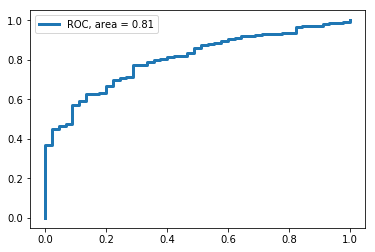

In [28]:
# ROC: Receiving Operation Curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_score = logmodel.decision_function(x_test)
fpr, tpr, _ = roc_curve(y_test, y_score)
auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, lw = 3, label = "ROC, area = {:0.2f}".format(auc))
plt.legend()